<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/OverfitTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from collections import OrderedDict


In [ ]:
def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [ ]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 



In [ ]:

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [ ]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


epoch:0, train acc:0.14333333333333334, test acc:0.1277
epoch:1, train acc:0.15666666666666668, test acc:0.1344
epoch:2, train acc:0.16333333333333333, test acc:0.1428
epoch:3, train acc:0.19333333333333333, test acc:0.1561
epoch:4, train acc:0.20666666666666667, test acc:0.1685
epoch:5, train acc:0.21333333333333335, test acc:0.176
epoch:6, train acc:0.25, test acc:0.196
epoch:7, train acc:0.2733333333333333, test acc:0.2154
epoch:8, train acc:0.29, test acc:0.2359
epoch:9, train acc:0.2966666666666667, test acc:0.2315
epoch:10, train acc:0.3233333333333333, test acc:0.2524
epoch:11, train acc:0.33666666666666667, test acc:0.2701
epoch:12, train acc:0.37, test acc:0.2901
epoch:13, train acc:0.38666666666666666, test acc:0.3078
epoch:14, train acc:0.38666666666666666, test acc:0.3149
epoch:15, train acc:0.4066666666666667, test acc:0.3309
epoch:16, train acc:0.4266666666666667, test acc:0.3424
epoch:17, train acc:0.44, test acc:0.3471
epoch:18, train acc:0.44333333333333336, test acc:0

epoch:157, train acc:0.8633333333333333, test acc:0.6985
epoch:158, train acc:0.87, test acc:0.6975
epoch:159, train acc:0.8566666666666667, test acc:0.6976
epoch:160, train acc:0.8633333333333333, test acc:0.6996
epoch:161, train acc:0.88, test acc:0.7078
epoch:162, train acc:0.8633333333333333, test acc:0.7089
epoch:163, train acc:0.8633333333333333, test acc:0.7023
epoch:164, train acc:0.87, test acc:0.6974
epoch:165, train acc:0.86, test acc:0.6997
epoch:166, train acc:0.8666666666666667, test acc:0.704
epoch:167, train acc:0.8666666666666667, test acc:0.6978
epoch:168, train acc:0.8666666666666667, test acc:0.7024
epoch:169, train acc:0.8733333333333333, test acc:0.6998
epoch:170, train acc:0.86, test acc:0.703
epoch:171, train acc:0.8733333333333333, test acc:0.7012
epoch:172, train acc:0.8733333333333333, test acc:0.6935
epoch:173, train acc:0.8666666666666667, test acc:0.6943
epoch:174, train acc:0.88, test acc:0.6986
epoch:175, train acc:0.88, test acc:0.697
epoch:176, train a

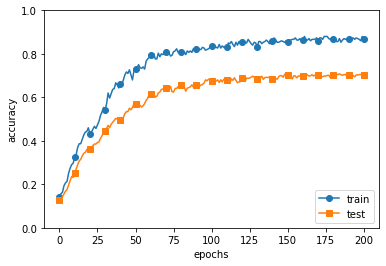

In [ ]:


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
